## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

from scipy.io import loadmat
from displayData import displayData, displayImage
from checkNNGradients import checkNNGradients

## Cargar datos

In [2]:
data = loadmat('ex4data1.mat')

Y = data['y'].ravel()
X = data['X']

w = loadmat('ex4weights.mat')

## Mostrar ejemplos

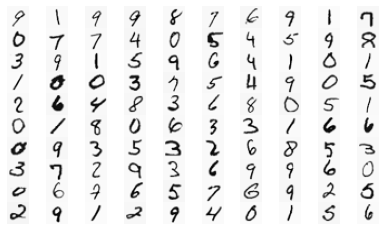

In [3]:
sample = np.random.choice(X.shape[0], 100)
fig, ax = displayData(X[sample, :])

## ONEHOT

In [4]:
m = len(Y)
input_size = X.shape[1]
num_labels = 10

Y = (Y - 1)
Y_onehot = np.zeros((m, num_labels))

for i in range(m):
    Y_onehot[i][Y[i]] = 1

## Inicializar valores

In [5]:
# m = X.shape[0]
# X = np.hstack([np.ones([m, 1]), X])
# n = X.shape[1]
# print(theta.shape)

## Inicializar Thetas

In [6]:
# def iniThetas (sizes):
#     """
#     Input: array of sizes without the +1
#     Output: dictionary of thetas init @0, except the first element -> @1
    
    
#     For example:
#         Theta1 = (25, 401)
#         Theta1 = (10, 26)
#     """
    
#     d = dict()
#     for i in range(1, len(sizes)):
#         name = "Theta" + str(i)
#         aux = np.zeros((sizes[i], sizes[i - 1]))
#         aux = np.hstack([np.ones([sizes[i], 1]), aux])
#         d[name] = aux
#         # print(d[name])
        
#     return d
        
# d = iniThetas([400, 25, 10])


## Función Sigmoide

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## Forward Propagation

In [8]:
def forward_prop(X, w):
    a1 = X
    a1 = np.hstack([np.ones([X.shape[0], 1]), a1])

    z2 = np.dot(w['Theta1'], a1.T)
    a2 = sigmoid(z2).T
    a2 = np.hstack([np.ones([a2.shape[0], 1]), a2])

    z3 = np.dot(w['Theta2'], a2.T)
    h = sigmoid(z3).T

    return a1, z2, a2, z3, h

## Función de Coste

In [9]:
def coste(X, Y, w, K, lam):
    m = X.shape[0]
    J_theta = 0    
    aux = 0
    _, _, _, _, h_theta = forward_prop(X, w)
    
    for i in range(m):
        aux +=np.sum(-Y[i] * np.log(h_theta[i])
                     - (1 - Y[i])* np.log(1 - h_theta[i]))
            
    
    J_theta = (1 / m) * aux
    
    # Regularizacion
    reg = 0

    for theta in w.keys():
        if "__" not in theta:
            reg += np.sum(np.square(w[theta][:, 1:]))

    reg *= (lam /(2 * m))

    # Coste Regularizado
    J_theta += reg
    
    return J_theta

In [10]:
# PRUEBAS
print("Coste sin regularizar:\t{}".format(coste(X, Y_onehot, w, Y_onehot.shape[0], 0)))
print("Coste regularizado:\t{}".format(coste(X, Y_onehot, w, Y_onehot.shape[0], 1)))

Coste sin regularizar:	0.28762916516131876
Coste regularizado:	0.3837698590909235


## Función de Gradiente

In [11]:
def gradiente(X, Y, w, lam):
    """
    Calcula el coste de la gradiente
    """
    m = X.shape[0]
    
    d = dict()
    d["delta1"] = np.zeros(w["Theta1"].shape)

    d["delta2"] = np.zeros(w["Theta2"].shape)
    a1, z2, a2, z3, h_theta = forward_prop(X, w)

    for i in range(m):
        # Calcular d2 y d3
        d3 = h_theta[i] - Y[i]                  # (10, )
        g_z2 = a2[i] * (1 - a2[i])              # (26, )
        d2 = np.dot(d3, w["Theta2"]) * g_z2     # (26, )
        #d2 = d2[1:]                             # (25, )
    
        # Actualizar deltas
        d["delta1"] += np.dot(d2[1:, np.newaxis], a1[i][np.newaxis, :])
        d["delta2"] += np.dot(d3[:, np.newaxis], a2[i][np.newaxis, :])

    d["delta1"] /= m
    d["delta2"] /= m
    
    #Regularizar deltas
    reg1 = ((lam / m) * w["Theta1"][:, 1:]) # No theta primera columna
    reg2 = ((lam / m) * w["Theta2"][:, 1:]) # No theta primera columna
    d["delta1"][:, 1:] += reg1              # j = 0 no tiene regularización
    d["delta2"][:, 1:] += reg2              # j = 0 no tiene regularización

    
    return np.concatenate(
        (np.ravel(d["delta1"]),
         np.ravel(d["delta2"]))
    )


## Backprop

In [12]:
def recolocar(params_rn, num_entradas, num_ocultas, num_etiquetas):
    """
    A partir de un único vector y el número de entradas, de nodos ocultos
    y etiquetas se devuelven los vectores Theta1 y Theta2, con los tamaños
    establecidos
    """
    Theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)],
                        (num_ocultas, (num_entradas + 1)))
    Theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):],
                        (num_etiquetas, (num_ocultas + 1)))
    return Theta1, Theta2

In [13]:
def backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, Y, reg):
    """
    Esta función devuelve una tupla (coste, gradiente) con el coste y
    el gradiente de una red neuronal de tres capas, con num_entradas,
    num_ocultas nodos en la capa oculta y num_etiquetas nodos en la
    capa de salida. Si m es el número de ejemplos de entrenamiento,
    la dimensiónde de 'X' es (m, num_entradas) y la de 'y'
    es (m, num_etiquetas)
    """
    w = dict()
    w["Theta1"], w["Theta2"] = recolocar(params_rn, num_entradas, num_ocultas, num_etiquetas)
    
    return coste(X, Y, w, Y.shape[0], reg), gradiente(X, Y, w, reg)

In [14]:
params_rn = np.concatenate(
    (
        np.ravel(w["Theta1"]),
        np.ravel(w["Theta2"])
    )
)

In [15]:
# Pruebas
backprop(params_rn, X.shape[1], 25, Y_onehot.shape[1], X, Y_onehot, 1)

(0.3837698590909235,
 array([ 6.18712766e-05, -2.11248326e-12,  4.38829369e-13, ...,
         4.70513145e-05, -5.01718610e-04,  5.07825789e-04]))

## Comprobar gradiente

In [16]:
print(checkNNGradients(backprop, 0))
print(checkNNGradients(backprop, 1))

grad shape:  (38,)
num grad shape:  (38,)
[ 5.27761168e-11 -2.55029895e-12  5.67280077e-12  9.17629861e-12
 -6.52669724e-11  2.08457210e-12 -1.07556533e-11 -4.38069164e-11
 -9.29989974e-11  7.04843822e-12 -4.64730199e-11 -1.24605812e-10
 -1.95650579e-11  5.45034504e-13 -8.24779828e-12 -2.49761462e-11
  2.15736456e-11 -4.96176017e-13  7.55695853e-12  2.51674931e-11
  6.03760375e-11  1.32927280e-11  9.03210839e-12  7.48807960e-12
  1.67883762e-11  2.10645668e-11  7.15513759e-11  1.56080704e-11
  7.11190828e-12  1.37491407e-11  1.70987668e-11  1.79336823e-11
  7.55120411e-11  1.60134683e-11  1.08387743e-11  1.78091986e-11
  1.43913215e-11  2.04546380e-11]
grad shape:  (38,)
num grad shape:  (38,)
[ 5.27761168e-11 -3.70814490e-12  6.60943522e-12  9.75092229e-12
 -6.52669724e-11  2.10972906e-12 -1.16537890e-11 -4.48128618e-11
 -9.29989974e-11  5.59485791e-12 -4.79407070e-11 -1.24423472e-10
 -1.95650579e-11 -8.44324610e-14 -9.22964483e-12 -2.43030734e-11
  2.15736456e-11  2.27595720e-13  7.5

## Valores aleatorios

In [17]:
def random_thetas(shape, E):
    """
    Recibe como parámetros las dimensiones y el Epsilon (rango -> [-E, E])
    
    Primero creamos una matriz de positivos y negativos
    Posteriormente creamos una matriz con números aleatorios positivos < Epsilon
    Multiplicamos las dos matrices, tenemos aleatorios positivos y negativos.
    
    Devuelve las dimensiones con valores aleatorios

    """
    posNeg = np.random.random((shape))
    pos = np.where(posNeg < .5)
    neg = np.where(posNeg >= .5)
    posNeg[pos] = 1
    posNeg[neg] = -1
        
    return (np.random.random((shape)) %E ) * posNeg

## Inicializar valores

In [18]:
data = loadmat('ex4data1.mat')

Y = data['y'].ravel()
X = data['X']


In [19]:
eIni = 0.12
it = 70
lambd = 0
hidden_layer = 25

Theta1_sh = (hidden_layer, X.shape[1] + 1)
Theta2_sh = (Y_onehot.shape[1], hidden_layer + 1)


thetas_random = dict()

thetas_random["Theta1"] = random_thetas(Theta1_sh, eIni)
thetas_random["Theta2"] = random_thetas(Theta2_sh, eIni)

th_random = np.concatenate(
    (
        np.ravel(thetas_random["Theta1"]),
        np.ravel(thetas_random["Theta2"])
    )
)

## Predicciones

In [20]:
def entrenar(backprop, thetas, X, Y, reg = 1, iterations = 70):
    
    # Thetas optimas
    res = opt.minimize(
        fun = backprop,
        x0 = thetas,
        args=(X.shape[1], 25, Y.shape[1], X, Y, reg),
        options={'maxiter': iterations},
        method='TNC',
        jac=True
    )

    # Recolocamos
    w = dict()
    w["Theta1"], w["Theta2"] = recolocar(res.x,
                                                 X.shape[1],
                                                 hidden_layer,
                                                 Y_onehot.shape[1])
    return w

w_opt = entrenar(backprop, th_random, X, Y_onehot, 1, 70)

In [21]:
def predecir_nn(X, Y, w):
    
    Y_hat = []
    _, _, _, _, pred = forward_prop(X, w)
    
    for i in range(pred.shape[0]):
        ejemplo = pred[i]
        num = np.argmax(ejemplo) + 1    # Va de 0 a 9, no de 1 a 10 -> +1
        Y_hat.append(num)
    
    Y_hat = np.array(Y_hat)
    
    return Y_hat

In [22]:
def precision_nn(X, Y, w):
    Y_hat = predecir_nn(X, Y, w)
        
    return np.round(
        np.sum(Y_hat == Y) / m * 100,
        decimals = 2
    )

In [23]:
print("La precisión de la Red Neuronal es de aproximadamente un: {}%"
      .format(precision_nn(X, Y, w_opt)))

La precisión de la Red Neuronal es de aproximadamente un: 92.52%


In [31]:
iterations = [ 10, 50, 100, 200, 300 ]
lambdas = [ 0.01, 0.03, 0.1, 0.3, 1, 3, 10 ]

for lambd in lambdas:
    for i in iterations:
        thetas = entrenar(backprop, th_random, X, Y_onehot, lambd, i)
        p = precision_nn(X, Y, thetas)
        print("Lambda: {}".format(lambd),
              "\tIteraciones: {}".format(i),
              "\tPrecisión:{}%\n".format(p)
             )


Lambda: 0.01 	Iteraciones: 10 	Precisión:60.32%

Lambda: 0.01 	Iteraciones: 50 	Precisión:89.94%

Lambda: 0.01 	Iteraciones: 100 	Precisión:95.34%

Lambda: 0.01 	Iteraciones: 200 	Precisión:99.58%

Lambda: 0.01 	Iteraciones: 300 	Precisión:99.98%

Lambda: 0.03 	Iteraciones: 10 	Precisión:60.32%

Lambda: 0.03 	Iteraciones: 50 	Precisión:89.94%

Lambda: 0.03 	Iteraciones: 100 	Precisión:95.44%

Lambda: 0.03 	Iteraciones: 200 	Precisión:99.94%

Lambda: 0.03 	Iteraciones: 300 	Precisión:100.0%

Lambda: 0.1 	Iteraciones: 10 	Precisión:60.32%

Lambda: 0.1 	Iteraciones: 50 	Precisión:89.76%

Lambda: 0.1 	Iteraciones: 100 	Precisión:95.3%

Lambda: 0.1 	Iteraciones: 200 	Precisión:99.72%

Lambda: 0.1 	Iteraciones: 300 	Precisión:99.98%

Lambda: 0.3 	Iteraciones: 10 	Precisión:60.4%

Lambda: 0.3 	Iteraciones: 50 	Precisión:89.54%

Lambda: 0.3 	Iteraciones: 100 	Precisión:96.66%

Lambda: 0.3 	Iteraciones: 200 	Precisión:99.84%



<ipython-input-9-72d493657df4>:9: RuntimeWarning: divide by zero encountered in log
  - (1 - Y[i])* np.log(1 - h_theta[i]))
<ipython-input-9-72d493657df4>:9: RuntimeWarning: invalid value encountered in multiply
  - (1 - Y[i])* np.log(1 - h_theta[i]))


Lambda: 0.3 	Iteraciones: 300 	Precisión:99.9%

Lambda: 1 	Iteraciones: 10 	Precisión:60.34%

Lambda: 1 	Iteraciones: 50 	Precisión:88.12%

Lambda: 1 	Iteraciones: 100 	Precisión:94.78%

Lambda: 1 	Iteraciones: 200 	Precisión:98.78%

Lambda: 1 	Iteraciones: 300 	Precisión:99.38%

Lambda: 3 	Iteraciones: 10 	Precisión:60.3%

Lambda: 3 	Iteraciones: 50 	Precisión:91.6%

Lambda: 3 	Iteraciones: 100 	Precisión:96.06%

Lambda: 3 	Iteraciones: 200 	Precisión:97.44%

Lambda: 3 	Iteraciones: 300 	Precisión:97.5%

Lambda: 10 	Iteraciones: 10 	Precisión:60.18%

Lambda: 10 	Iteraciones: 50 	Precisión:86.28%

Lambda: 10 	Iteraciones: 100 	Precisión:93.9%

Lambda: 10 	Iteraciones: 200 	Precisión:94.1%

Lambda: 10 	Iteraciones: 300 	Precisión:94.34%

